In [98]:
# Point to configuration files
import sys
sys.path.append('/global/cfs/projectdirs/dune/www/data/2x2/simulation/rvizarr_dev/2x2/Thesis_2x2')
# Import python packages required for analysis
from setup import *
from collections import Counter
# Import CAF Plotting libraries
import plot_manager
importlib.reload(plot_manager)

<module 'plot_manager' from '/global/cfs/projectdirs/dune/www/data/2x2/simulation/rvizarr_dev/2x2/Thesis_2x2/plot_manager.py'>

In [70]:
# SIMULATION PARAMETERS
beta, mu = 33.7, 96*np.pi/180 # Twiss parameters
emmitance = 3*np.pi # mm mrad
n_particles = 1000
M = np.array([[np.cos(mu), beta * np.sin(mu)],
             [-np.sin(mu)/beta, np.cos(mu)]]) # Transfer matrix
print(M)

[[-1.04528463e-01  3.35153879e+01]
 [-2.95110355e-02 -1.04528463e-01]]


In [71]:
# BEAM GENERATOR
def get_beam(n_particles):
    x = np.random.normal(0, 1.0, n_particles) # initial width of 1mm
    x_prime = np.random.normal(0, 0.05, n_particles) # initial width of 0.05mrad
    return np.vstack((x, x_prime)).T # return (x,x') pairs in array

In [72]:
# IS LOST FROM THE BOOSTER?
is_lost = lambda x, x_prime: (x**2/beta + beta*x_prime**2) > emittance # boolean, true if lost

In [73]:
# GET THETA RMS
theta_RMS = lambda x : 1000*(13.6/(0.71*954))*np.sqrt(x/35600)

In [151]:
# PARTICLE TRAJECTORY RECOVERY
def get_trajectory_with_RMS(x0, lattice_elements, x=0): # Make theta RMS = 0 by default
    trajectory = [x0]
    x0 = M @ x0
    x0[1] += np.random.normal(0, theta_RMS(x))
    if is_lost(x0[0], x0[1]): return None
    trajectory.append(x0)
    for lattice in range(2,lattice_elements+1):
        x0 = M @ x0
        if x == 5:
            random_float = np.random.uniform(0, 100)
            if (lattice % 24 == 0) and (random_float<=5): x0[1] += np.random.normal(0, theta_RMS(0))
            if (lattice % 24 == 0) and (random_float>5): x0[1] += 0
        else:
            if (lattice % 24 == 0): x0[1] += np.random.normal(0, theta_RMS(x))
        if is_lost(x0[0], x0[1]): return None
        trajectory.append(x0)
    return np.array(trajectory)

In [202]:
# PLOT GENERATOR
def plot_beam_state(particles, title):
    fig = plt.figure(figsize=(15, 5))
    
    # Phase space plot
    ax1 = fig.add_subplot(131)
    ax1.plot(particles[:,0], particles[:,1], '.', markersize=1.5)
    ax1.set_xlabel('x (mm)')
    ax1.set_ylabel("x' (mrad)")
    ax1.set_title('Phase Space')
    ax1.grid(True)
    
    # x projection
    ax2 = fig.add_subplot(132)
    ax2.hist(particles[:,0], bins=50, density=True)
    ax2.set_xlabel('x (mm)')
    ax2.set_title('x Distribution')
    
    # x' projection
    ax3 = fig.add_subplot(133)
    ax3.hist(particles[:,1], bins=50, density=True)
    ax3.set_xlabel("x' (mrad)")
    ax3.set_title("x' Distribution")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

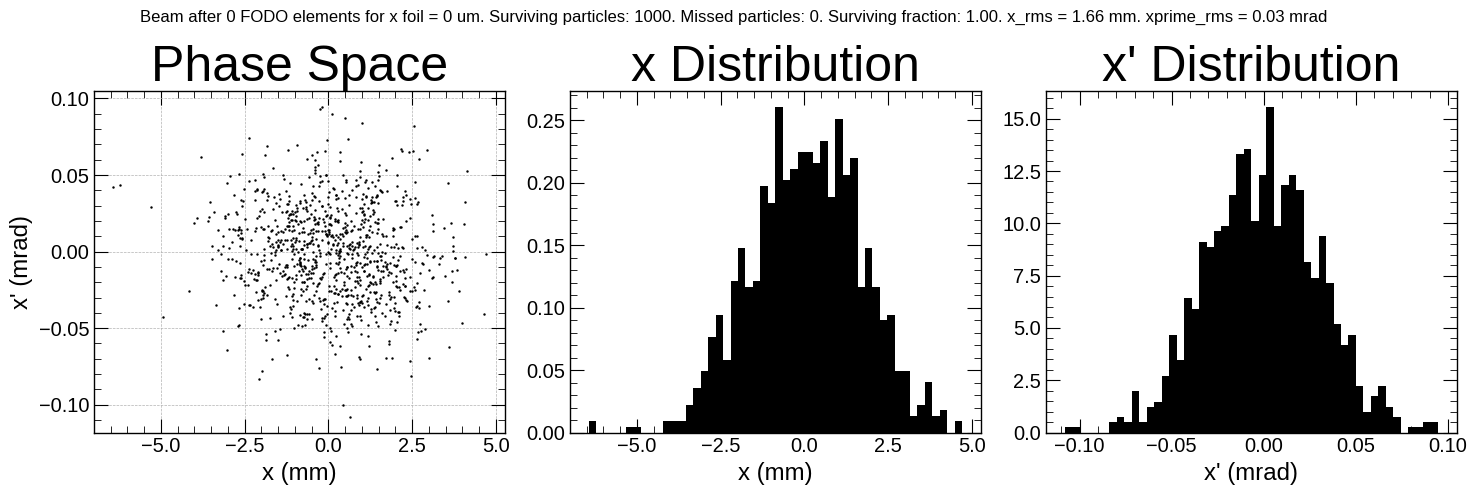

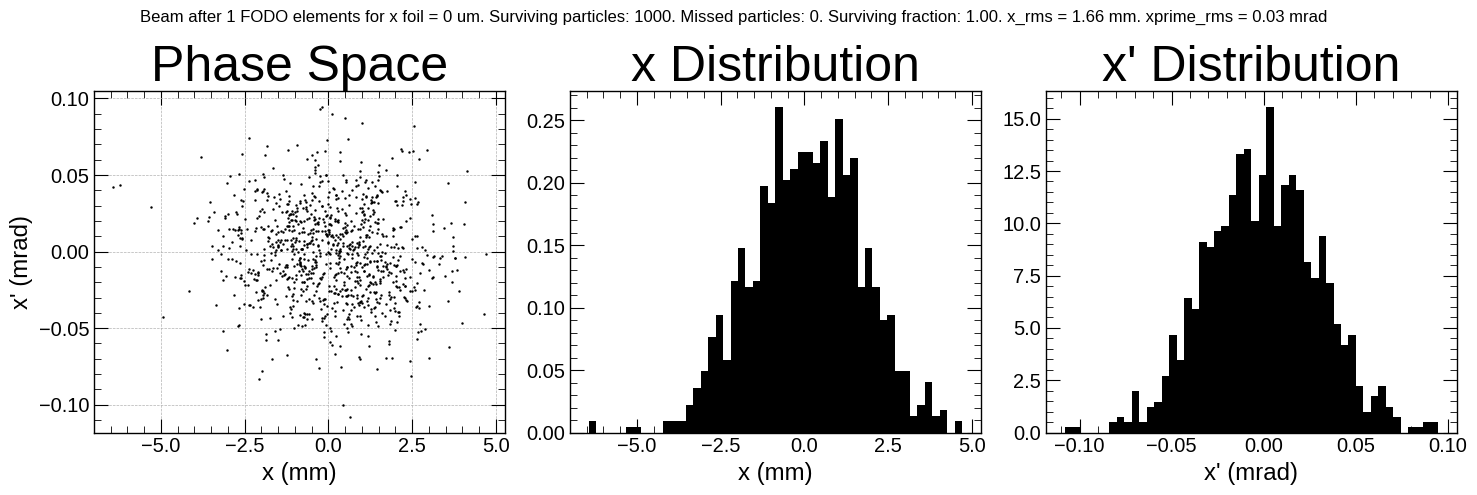

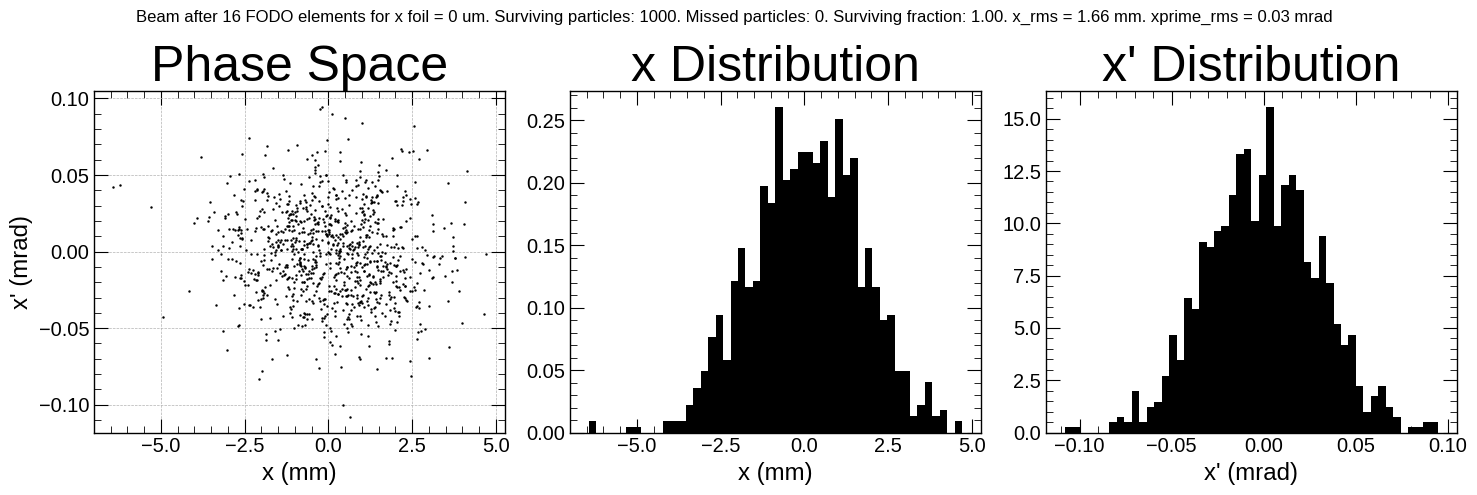

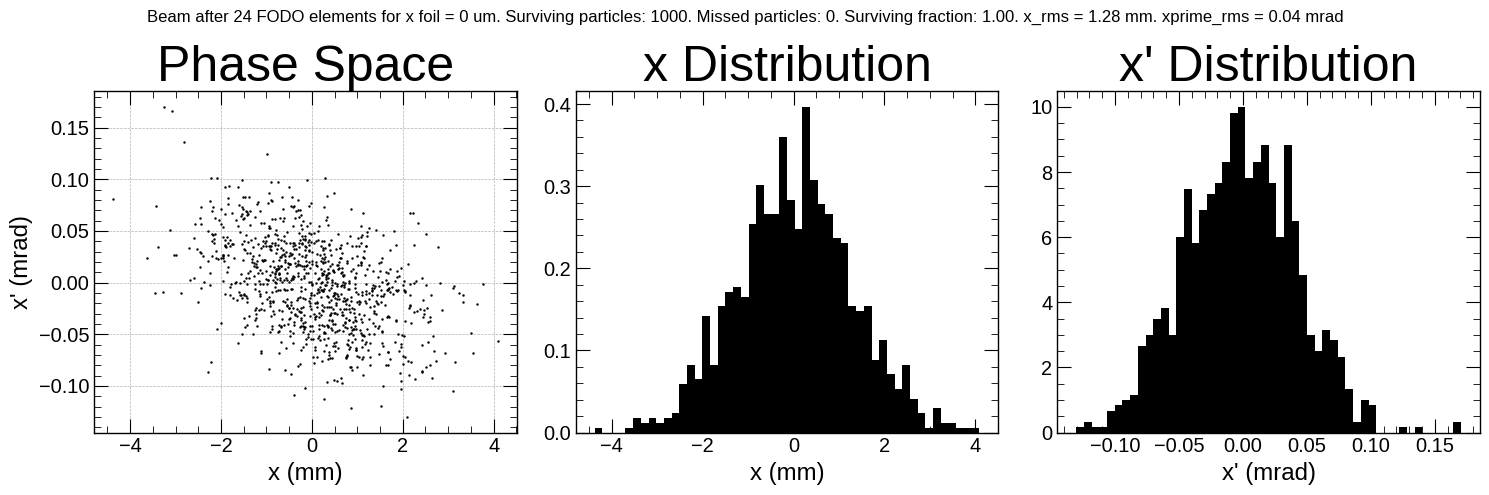

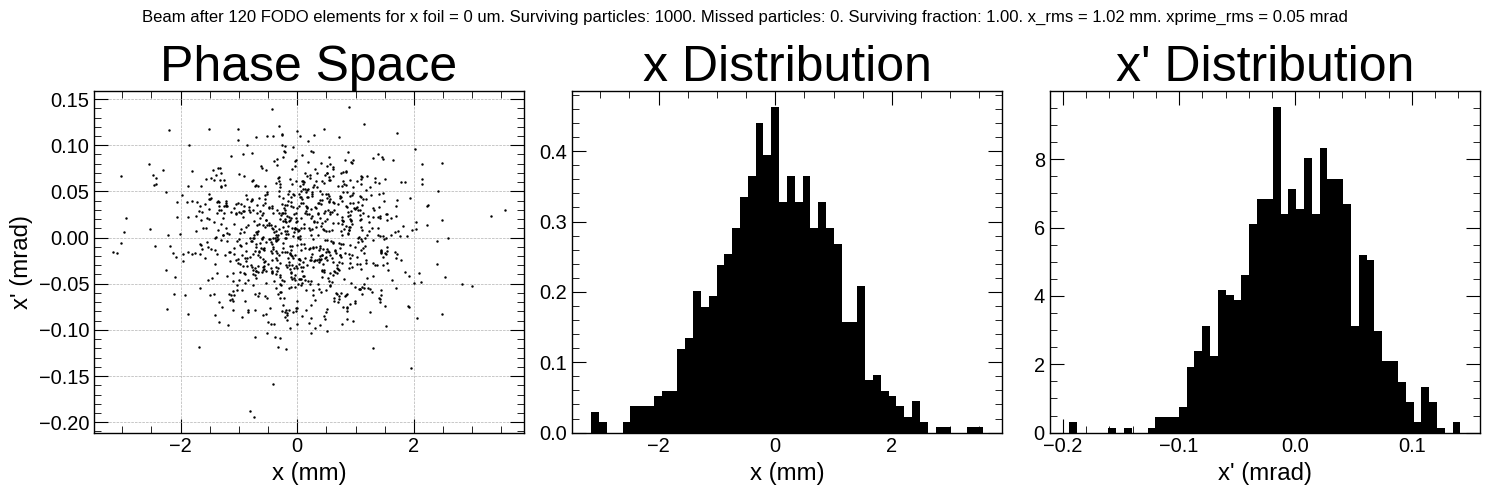

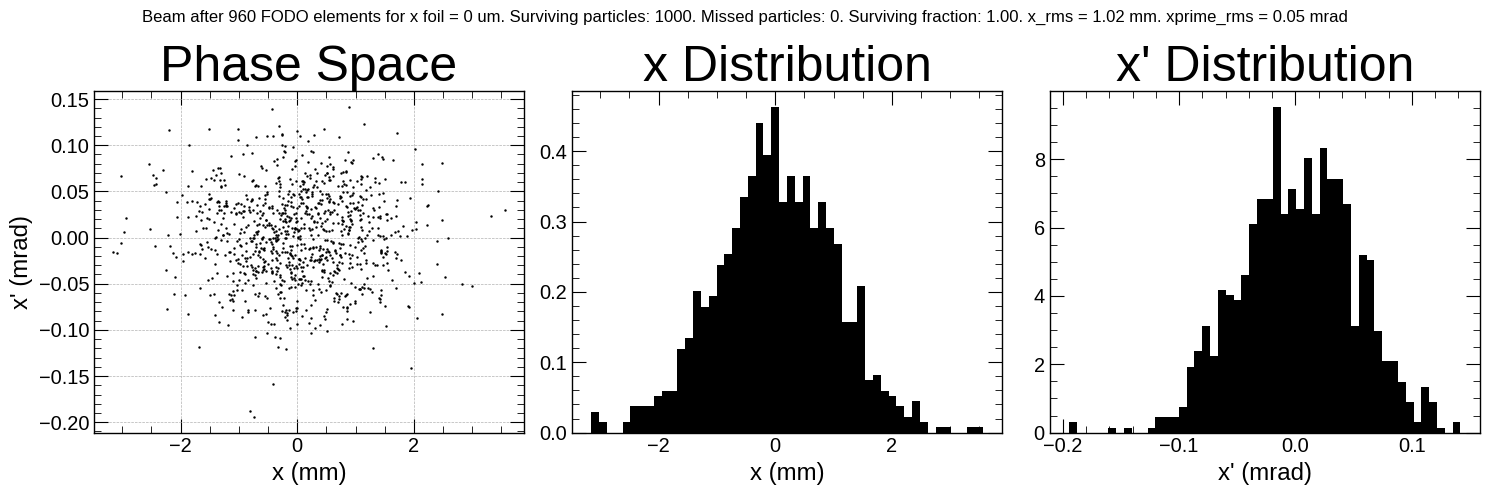

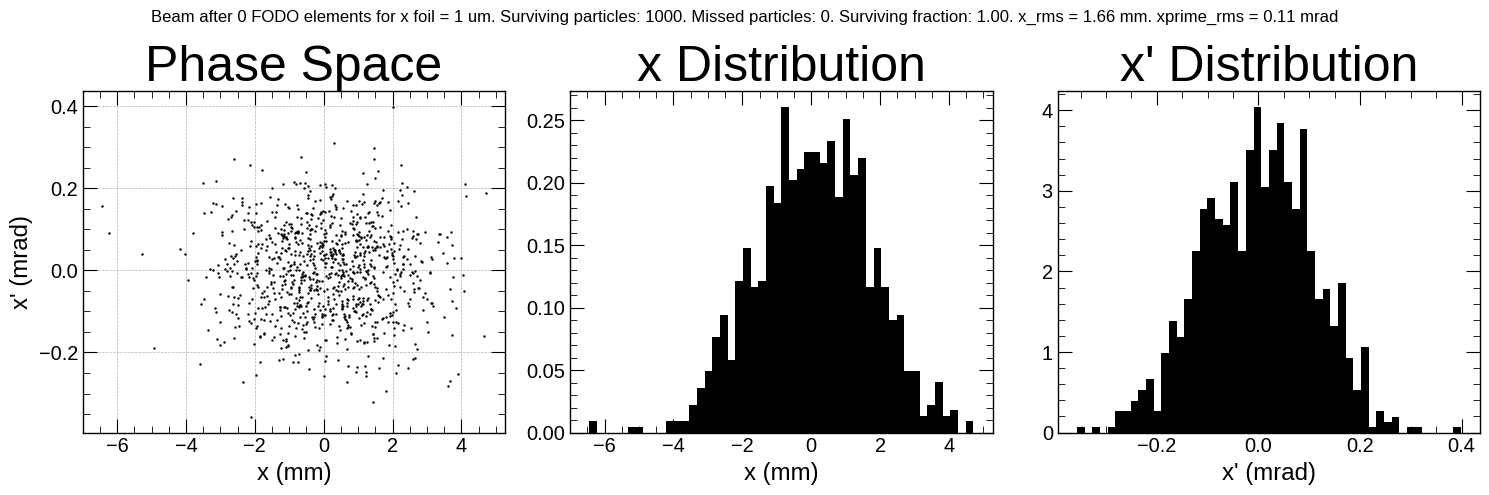

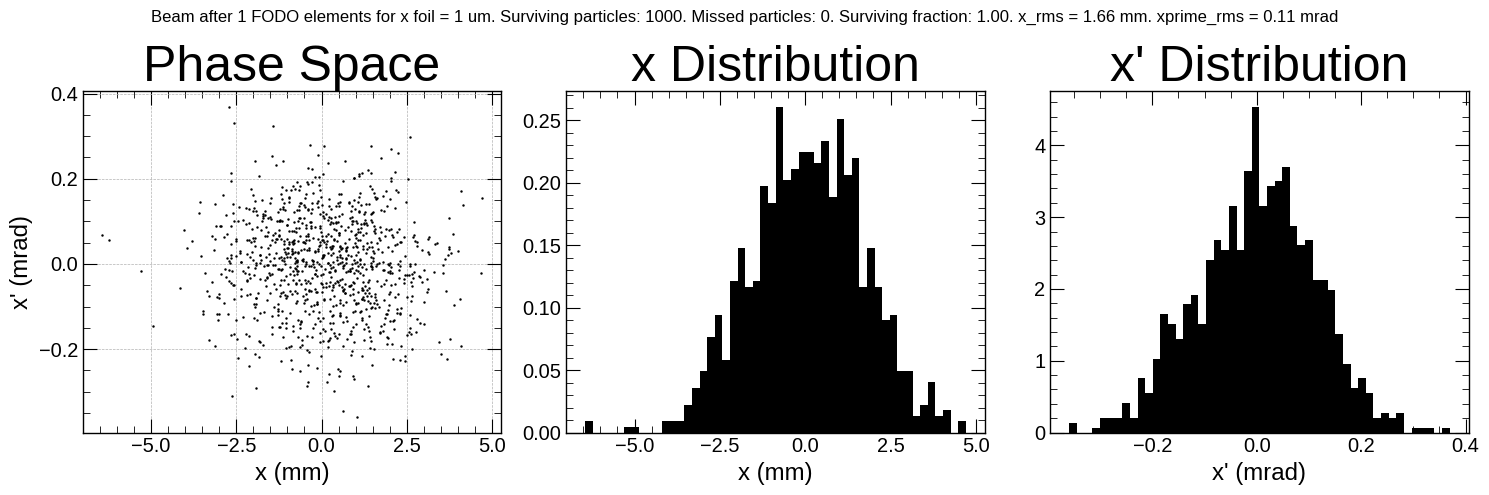

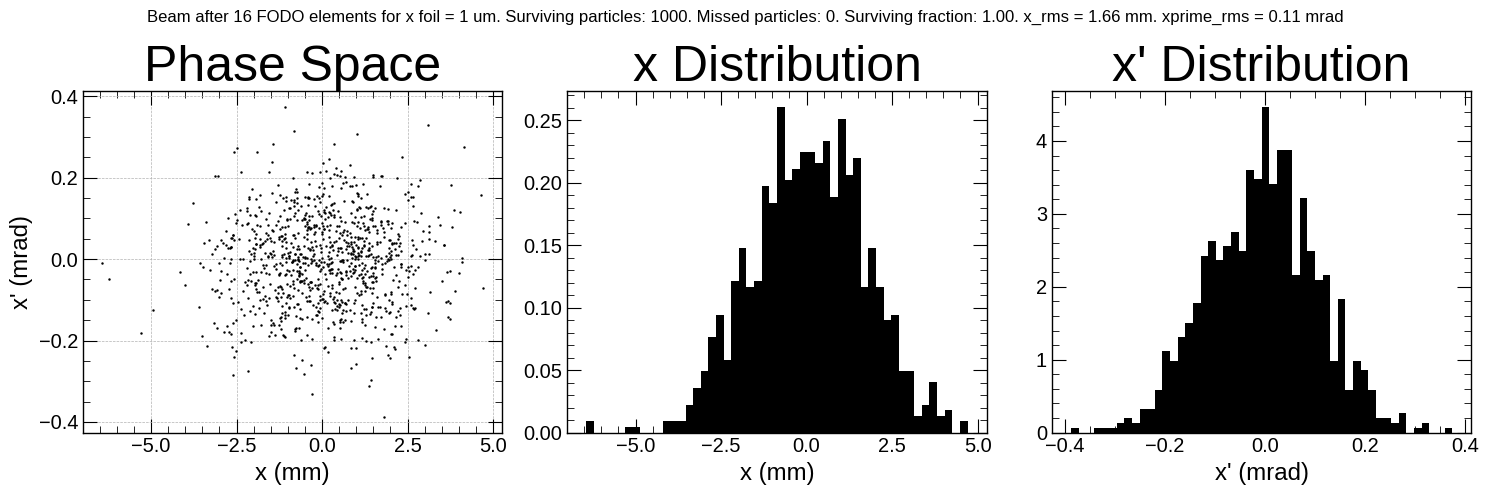

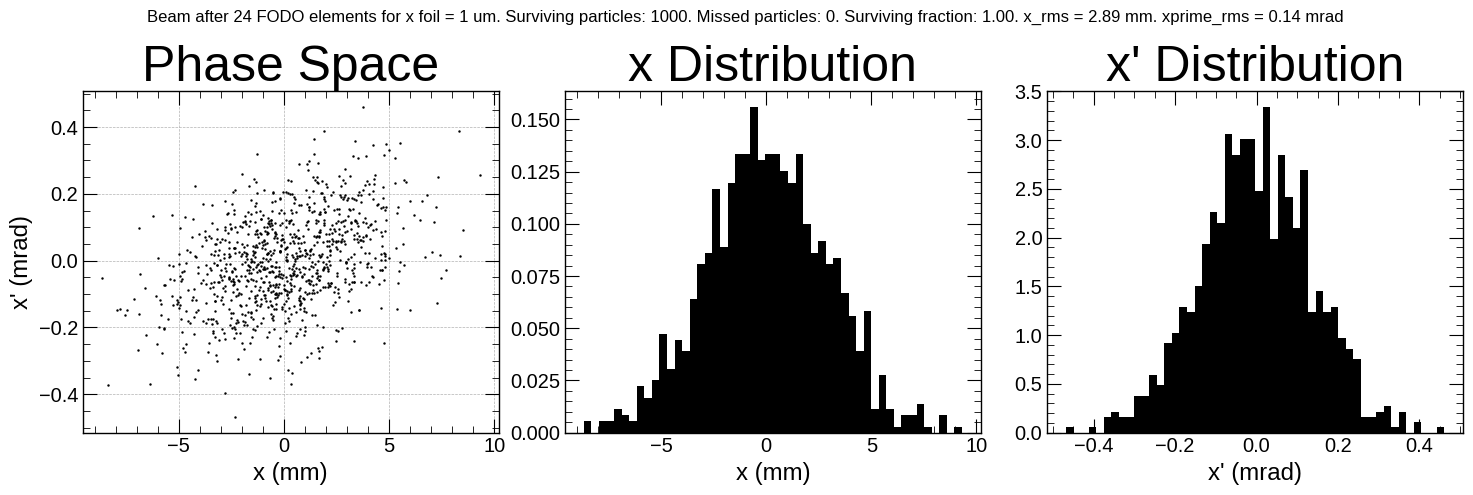

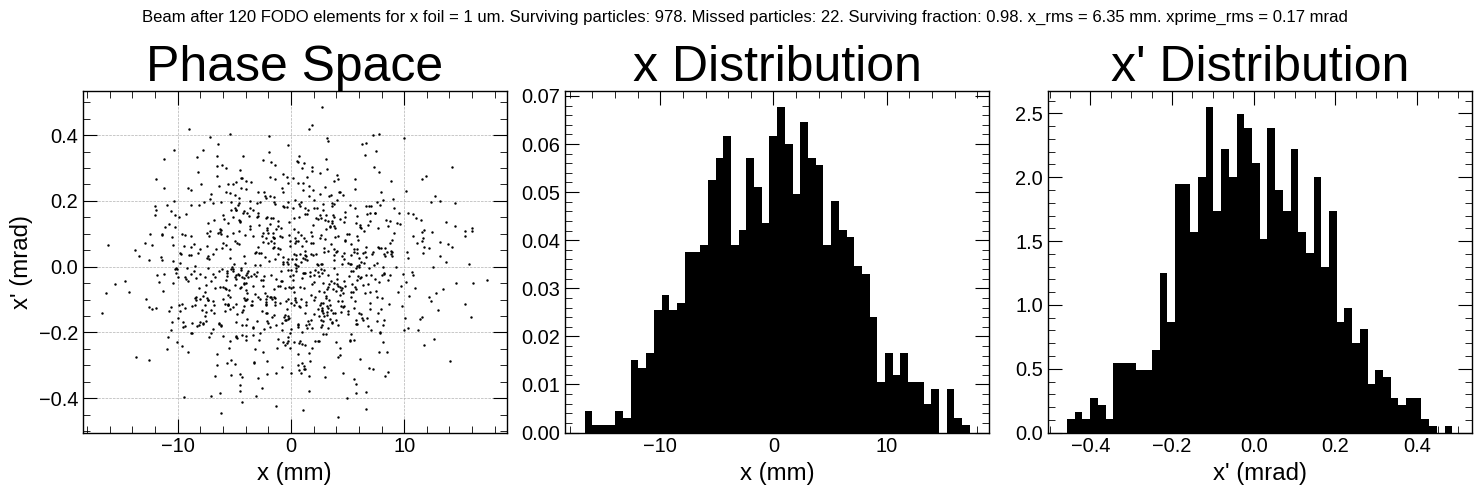

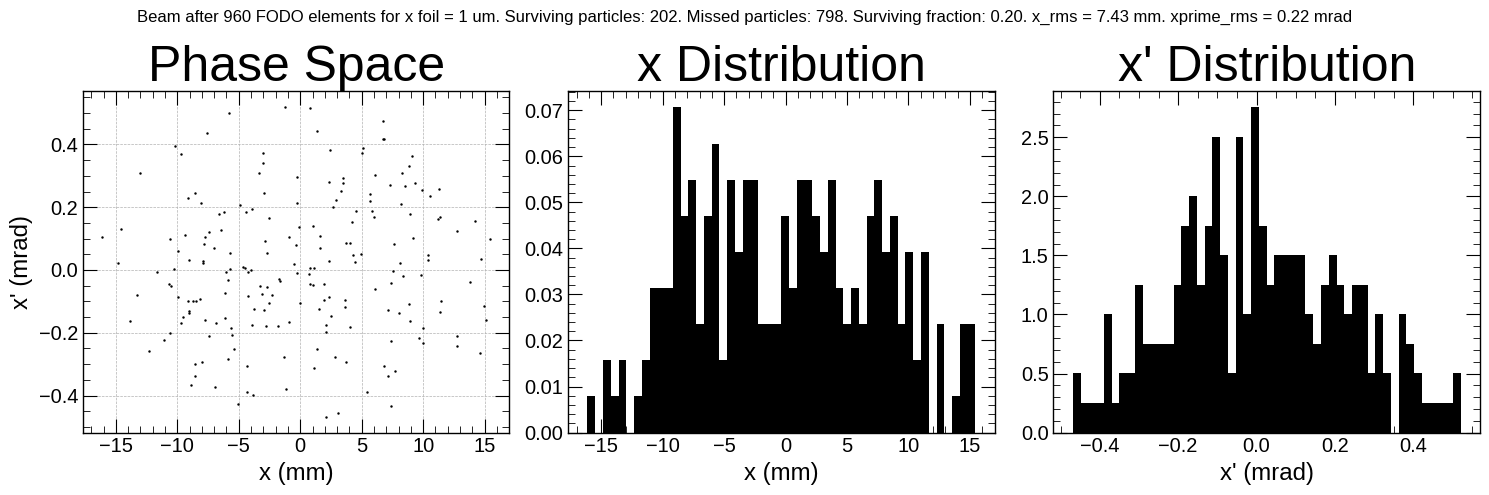

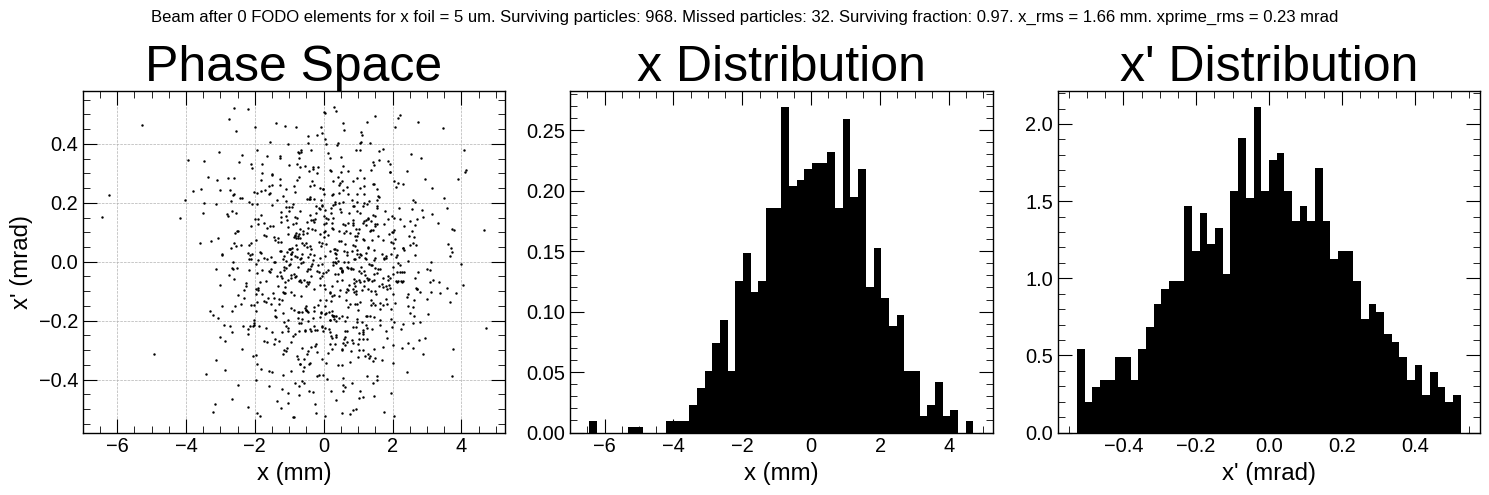

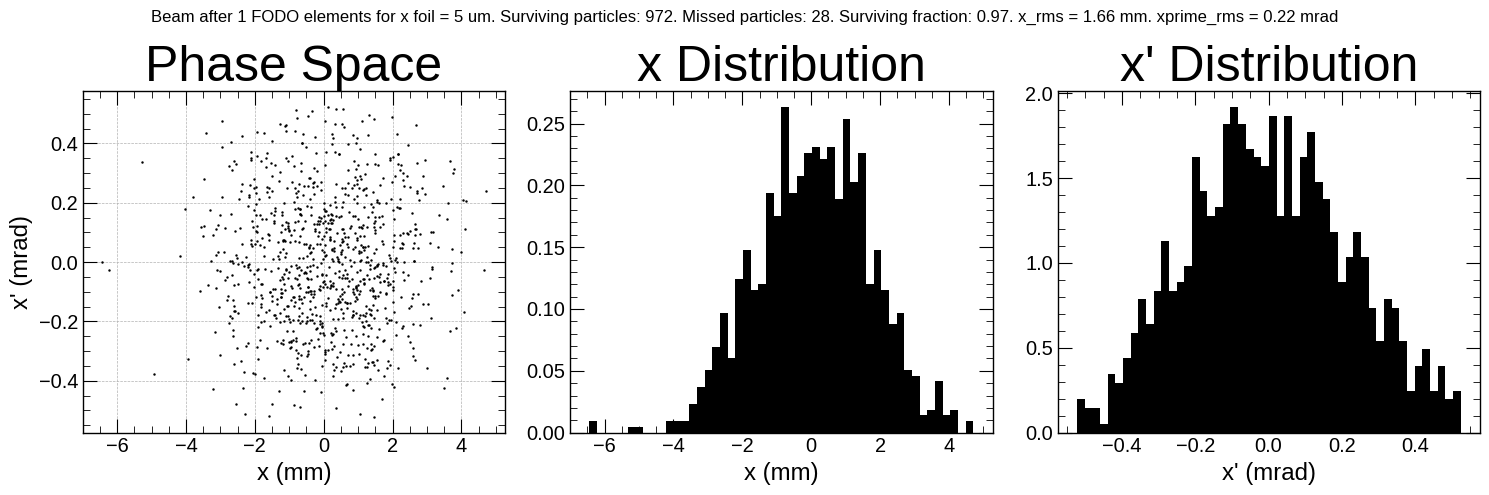

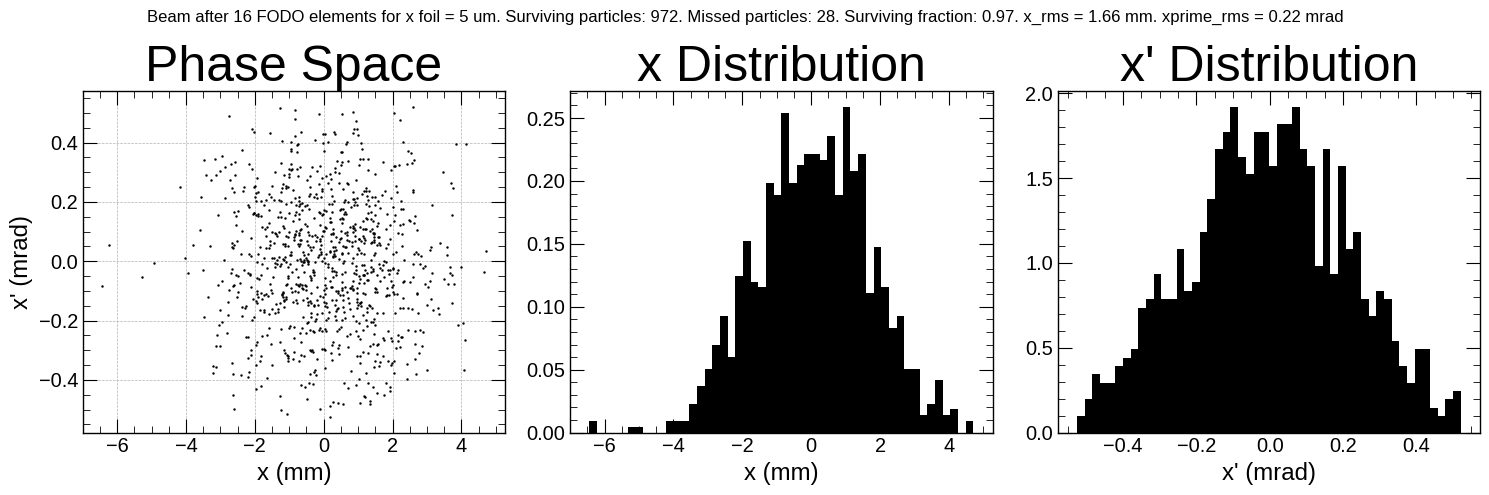

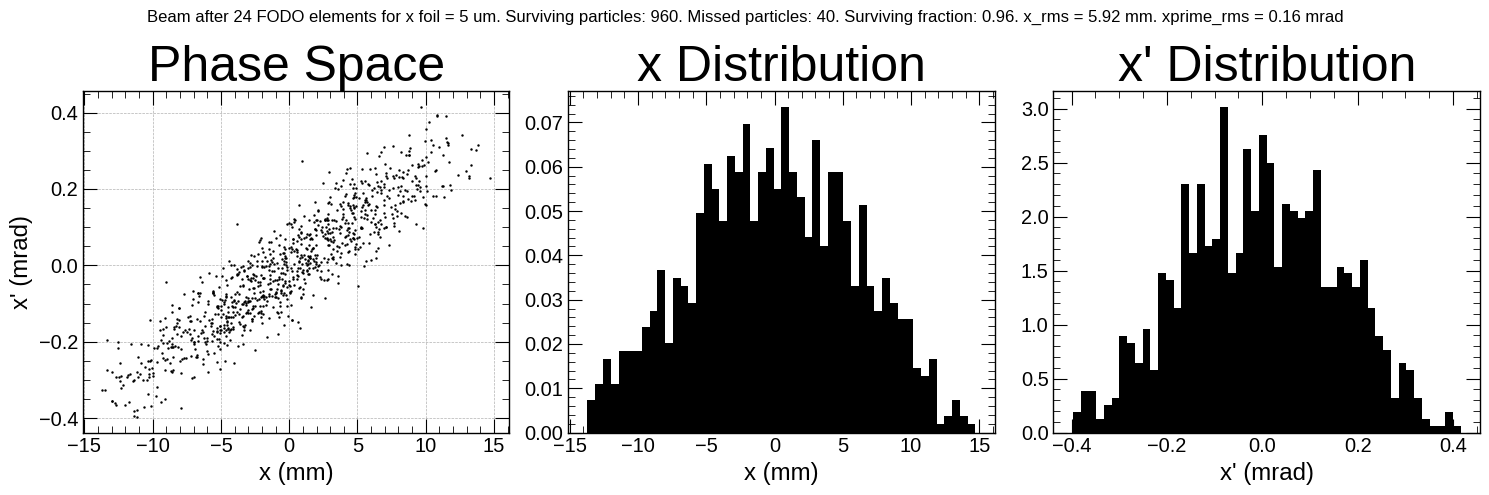

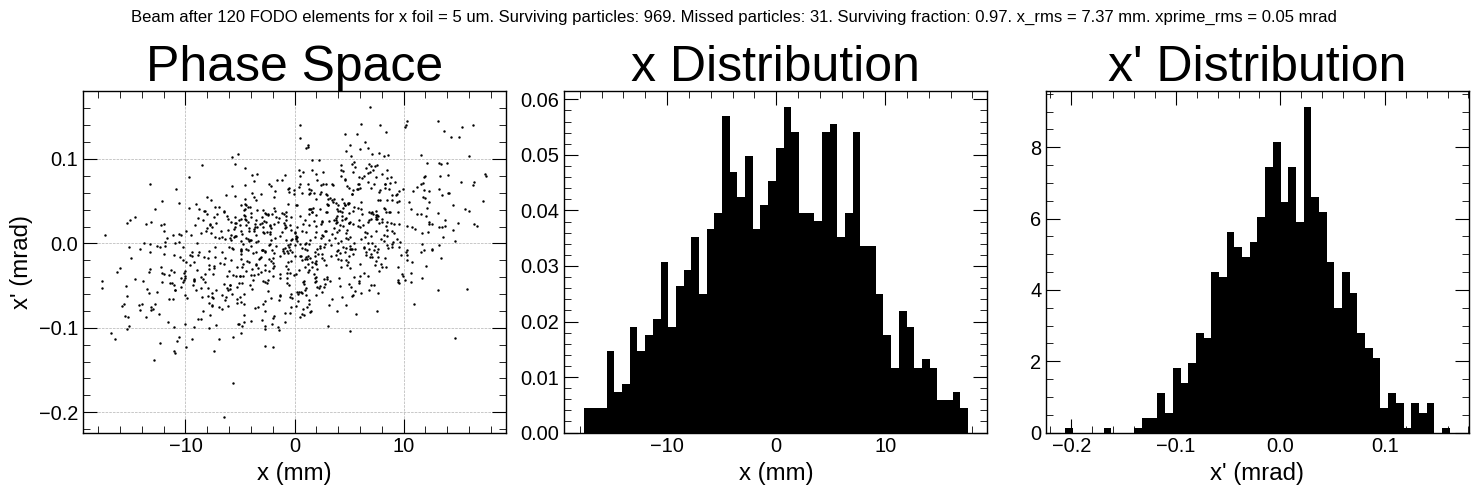

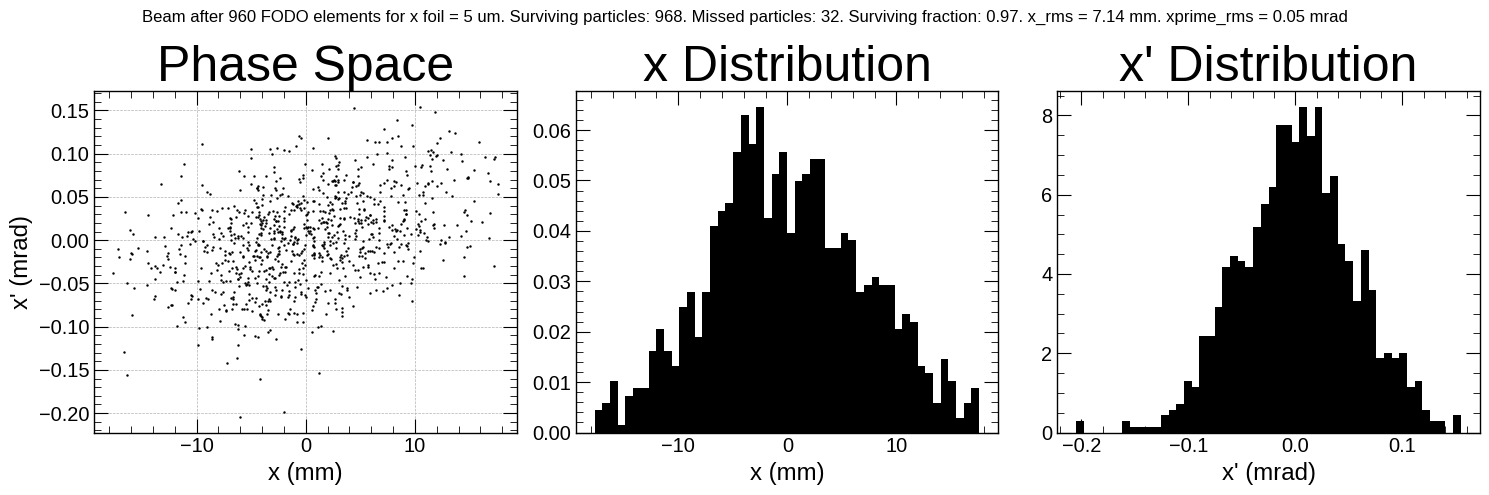

In [204]:
initial_beam = get_beam(n_particles)
for x_foil in [0,1,5]: # um
    for fodo in [0,1,16,24,120,960]:
        beam_end_positions = []
        for particle in initial_beam:
            trajectories = get_trajectory_with_RMS(particle, fodo, x=x_foil) # Array of particle positions
            if trajectories is not None:
                beam_end_positions.append(list(trajectories[-1])) # Saving only last particle position in phase space
        beam_end_positions = np.array(beam_end_positions)
        surviving_particles = len(beam_end_positions)
        missed_particles = n_particles - surviving_particles
        fraction = surviving_particles/n_particles
        x_rms, xprime_rms = np.sqrt(np.mean(beam_end_positions[:, 0]**2)), np.sqrt(np.mean(beam_end_positions[:, 1]**2))
        plot_beam_state(beam_end_positions, f'Beam after {fodo} FODO elements for x foil = {x_foil} um. Surviving particles: {surviving_particles}. Missed particles: {missed_particles}. Surviving fraction: {fraction:.2f}. x_rms = {x_rms:.2f} mm. xprime_rms = {xprime_rms:.2f} mrad')